In this notebook, we demonstrate applying the Voronoi tests using the modules on an example sample.

In [2]:
import graph_create, voronoi_local, jaccard_similarity, center_predict, figure_plot

import pandas as pd
import numpy as np

from scipy.spatial import Voronoi

-----

## Read in the graph

We read in the vein network and the dots as a combined graph object, with the single dots in non overlapping faces highlighted in orange.

In [3]:
sample = 'PileaTLeaf2'
dot_folder= 'sample_example'
vein_folder= 'sample_example'

G = graph_create.graph_creation(sample, dot_folder, vein_folder)

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.



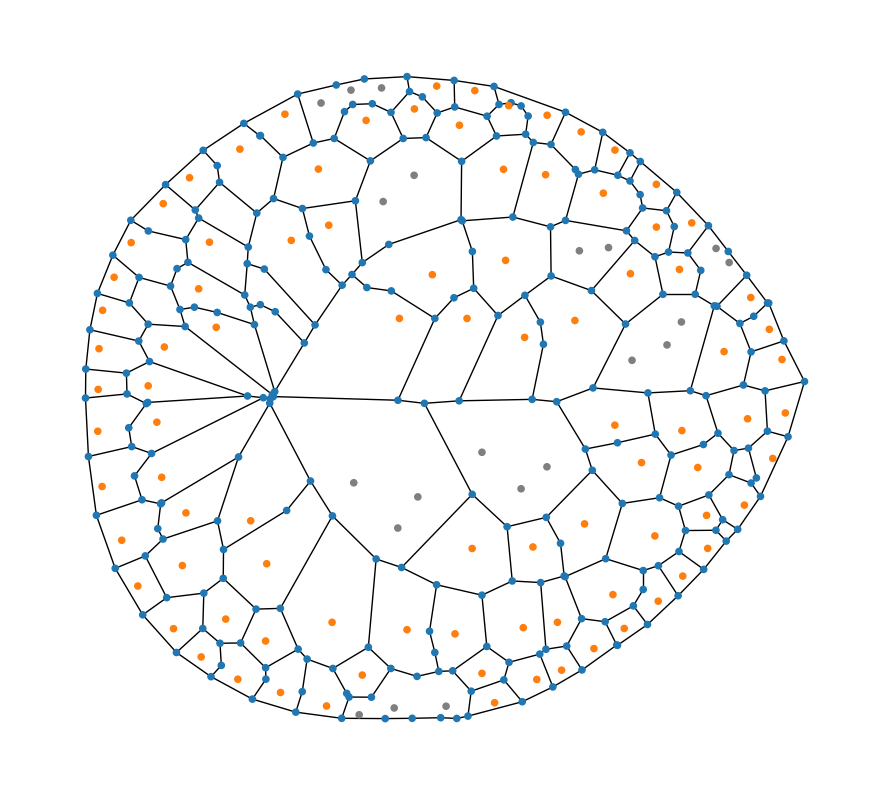

In [4]:
figure_plot.quick_plot(G)

-----

## Perform Voronoi I test

For the eligible hydathodes, we locally test the voronoi properties between them and hydathodes in the adjacent faces. We ask whether the line segment connecting two dots is perpendicualar to the shared edges of the face, and whether their distance to the edge is the same, and record the errors.

In [5]:
adj_faces_mat, shared_edges_mat = voronoi_local.shared_edges(G, threshold = 50)
rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat,G.graph['dots_passed'], G, dot_bool = True)
rst[2]

,mean angle error,std angle error,mean distance error,std distance error
0,8.380696,6.707946,0.132071,0.111583


In [6]:
print(f'The number of test pairs we have in this sample is {rst[1].shape[0]}.')

The number of test pairs we have in this sample is 181.


We use the centroid, mid-point and random dots in the face as baselines for the local test.

In [7]:
# baseline local tests:
cent_in_faces, mid_in_faces, rand_in_faces = voronoi_local.random_n_centroid(G)

In [8]:
centroid_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat, cent_in_faces)
midpoint_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat ,mid_in_faces)
random_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat, rand_in_faces)

### Visualize the eligible test pairs:

In [9]:
G_dual = graph_create.make_dual(G, cent_in_faces, mid_in_faces, rand_in_faces, rst[0])

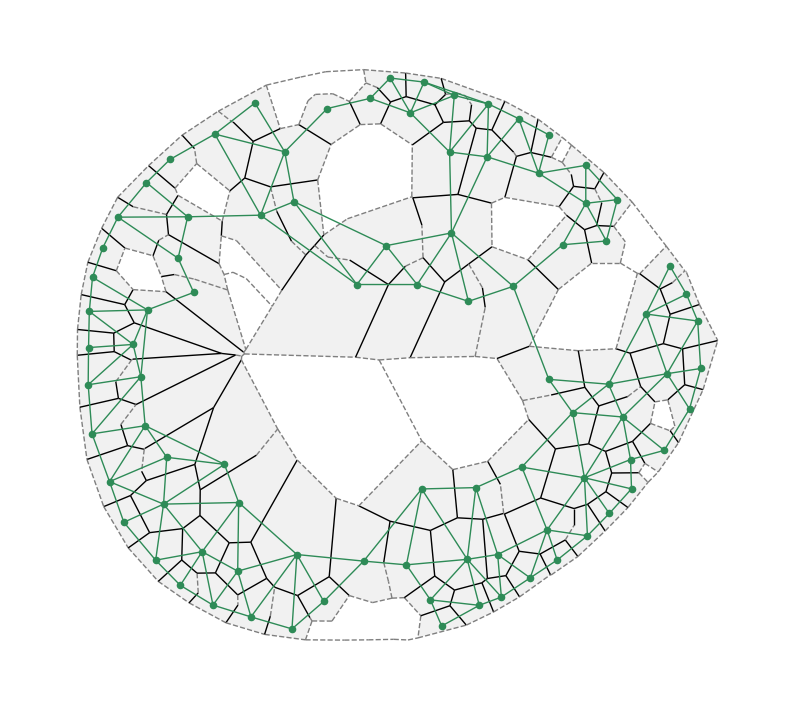

In [10]:
figure_plot.plot_testable(G, G_dual)

In [11]:
# combine local test results:
rst_df = rst[1]
rst_df['type'] = 'hydathode'
cent_df = centroid_rst[1]
cent_df['type'] = 'centroid'
mid_df = midpoint_rst[1]
mid_df['type'] = 'midpoint'
rand_df = random_rst[1]
rand_df['type'] = 'random'

df = pd.concat([rst_df, cent_df, mid_df, rand_df])
df.reset_index(level=0, inplace=True)


### Visualize reference pointsets:

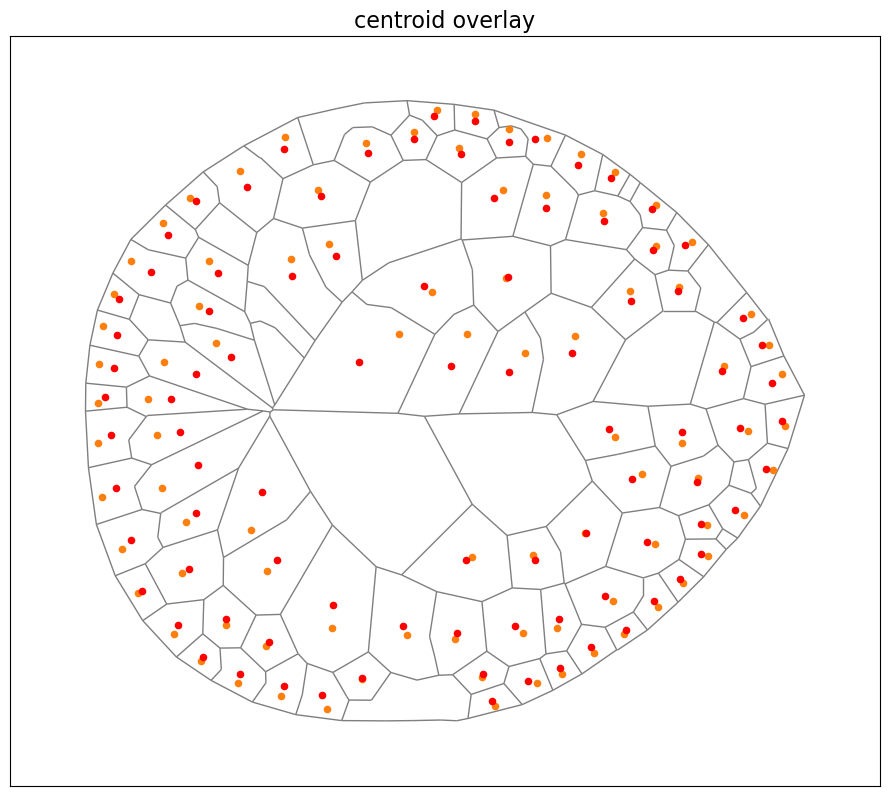

In [12]:
figure_plot.plot_baseline(G, G_dual, pt_type = 'centroid')

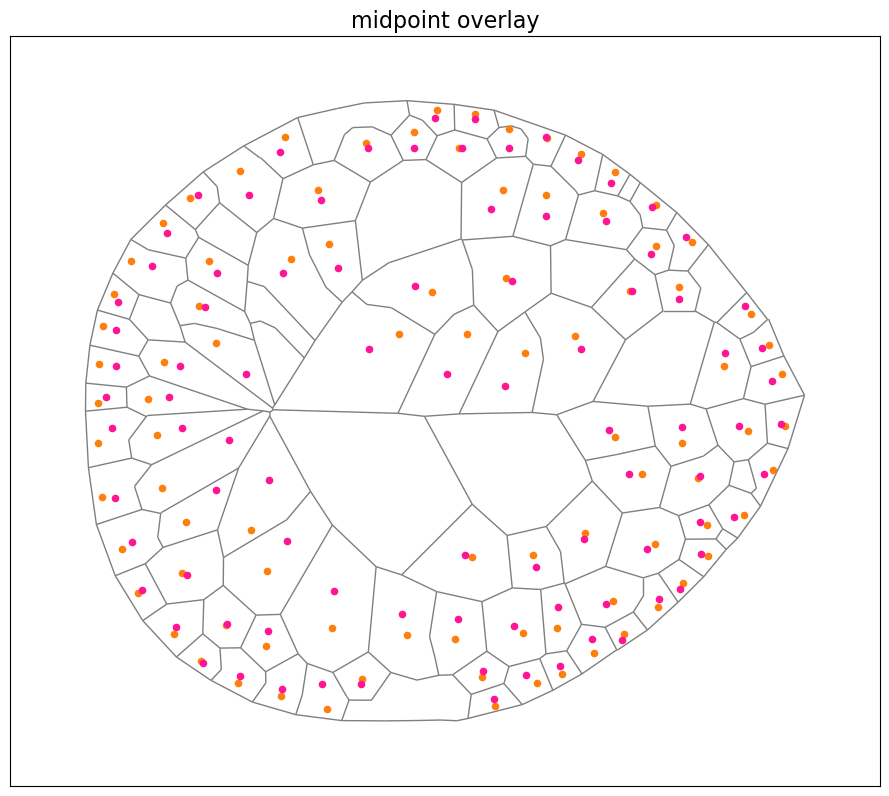

In [13]:
figure_plot.plot_baseline(G, G_dual, pt_type = 'midpoint')

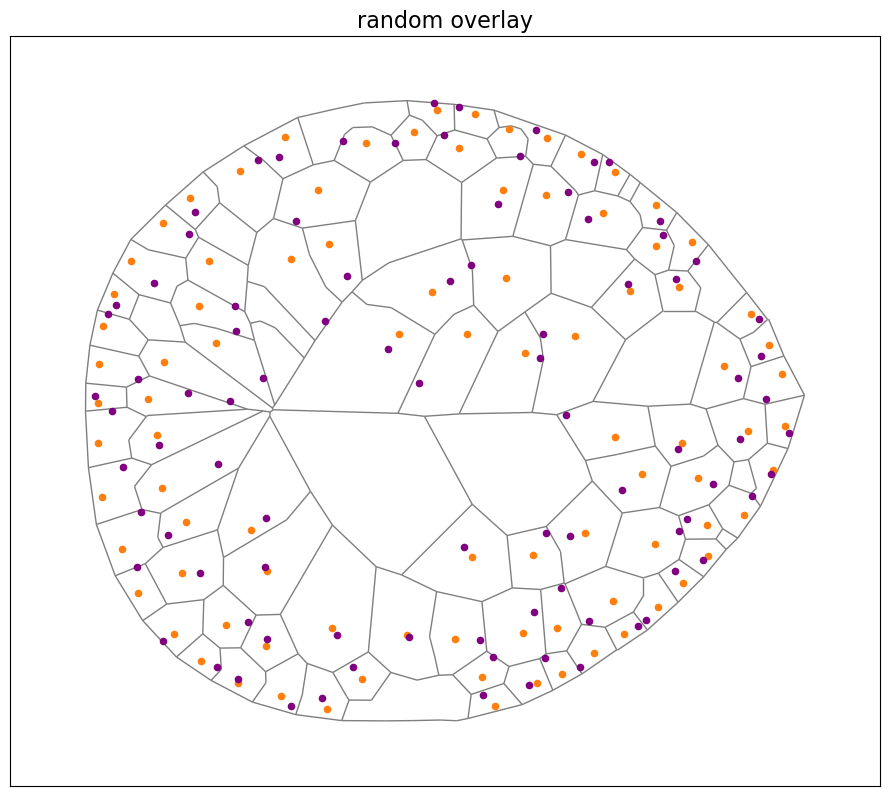

In [14]:
figure_plot.plot_baseline(G, G_dual, pt_type = 'random')

In [15]:
baseline_summary = pd.DataFrame(np.array([rst[2].iloc[0].tolist(), centroid_rst[2].iloc[0].tolist(), midpoint_rst[2].iloc[0].tolist(), random_rst[2].iloc[0].tolist()]), 
                                    columns = ['angle_mean', 'angle_std', 'dist_mean', 'dist_std'],
                                    index = ['dot', 'centroid', 'midpoint','random'])

In [16]:
baseline_summary

,angle_mean,angle_std,dist_mean,dist_std
dot,8.380696,6.707946,0.132071,0.111583
centroid,10.125135,8.245539,0.165632,0.129926
midpoint,12.585426,9.609237,0.205141,0.157367
random,21.261526,15.810567,0.388264,0.289355


### Compare test performance:

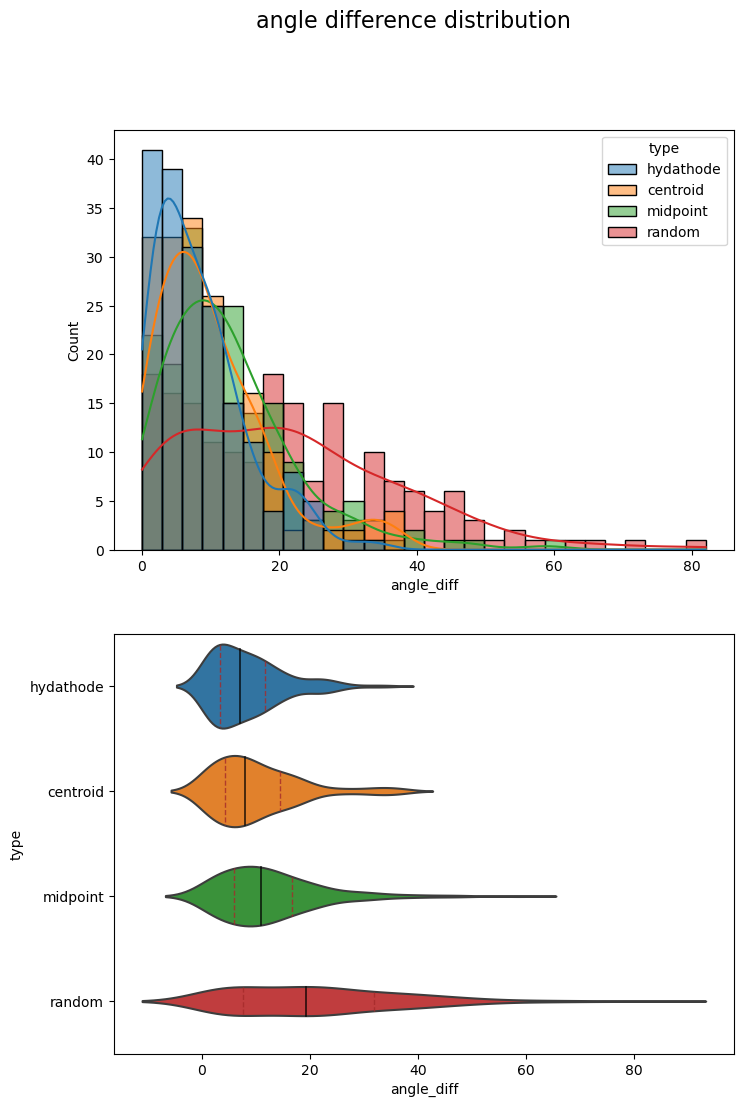

In [17]:
# angle test
figure_plot.plot_dist(df, test = 'angle')

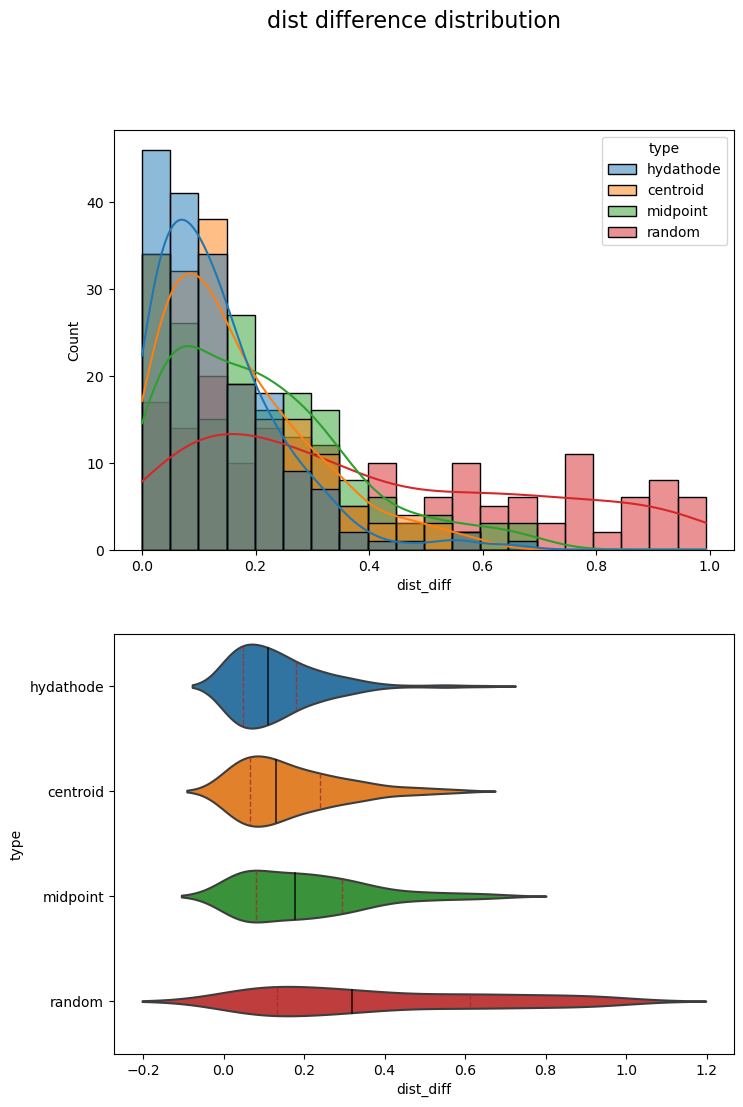

In [18]:
# dist test
figure_plot.plot_dist(df, test = 'dist')

-----

## Perform Voronoi II test

We collect the error when overlapping the true Voronoi graph with the vein graph, and compare them to the reference point sets.

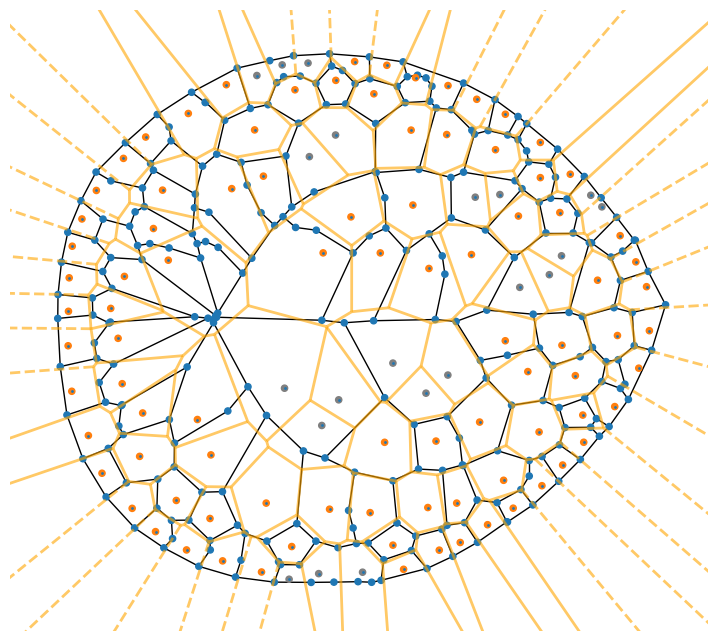

In [19]:
seeds = [n for n in G.nodes if G.nodes[n]['type'] != 'vein']
vor = Voronoi(seeds)
figure_plot.plot_voronoi(G, vor)

In [20]:
bounded_regions = jaccard_similarity.bounded_polygons(G, vor)
J_list = jaccard_similarity.overlap_test(G, seeds, bounded_regions, type = 'dot')

In [21]:
single_dot = [G.nodes[seed]['type'] == 'single_dot' for seed in seeds]

In [22]:
centroid_seeds, midpoint_seeds, random_seeds = jaccard_similarity.hybrid_seeds(G)

centroid_vor = Voronoi(centroid_seeds)
midpoint_vor =  Voronoi(midpoint_seeds)
random_vor = Voronoi(random_seeds)

centroid_bounded_regions = jaccard_similarity.bounded_polygons(G, centroid_vor)
midpoint_bounded_regions = jaccard_similarity.bounded_polygons(G, midpoint_vor)
random_bounded_regions = jaccard_similarity.bounded_polygons(G, random_vor)

centroid_J_list = jaccard_similarity.overlap_test(G, seeds, centroid_bounded_regions, type = 'centroid')
midpoint_J_list = jaccard_similarity.overlap_test(G, seeds, midpoint_bounded_regions, type = 'midpoint')
random_J_list = jaccard_similarity.overlap_test(G, seeds, random_bounded_regions, type = 'random')

J_df = pd.DataFrame(np.array([J_list, centroid_J_list, midpoint_J_list, random_J_list ]).T, columns = ['dots', 'centroid', 'midpoint', 'random'])

In [23]:
J_df.mean() 

dots        0.727779
centroid    0.708472
midpoint    0.658440
random      0.457756
dtype: float64

### Visualize Voronoi II overlap error: 

/Users/xinzheng/Desktop/Desktop/VoronoiVein/voronoi_tests/figure_plot.py:366: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for ploy in geom:


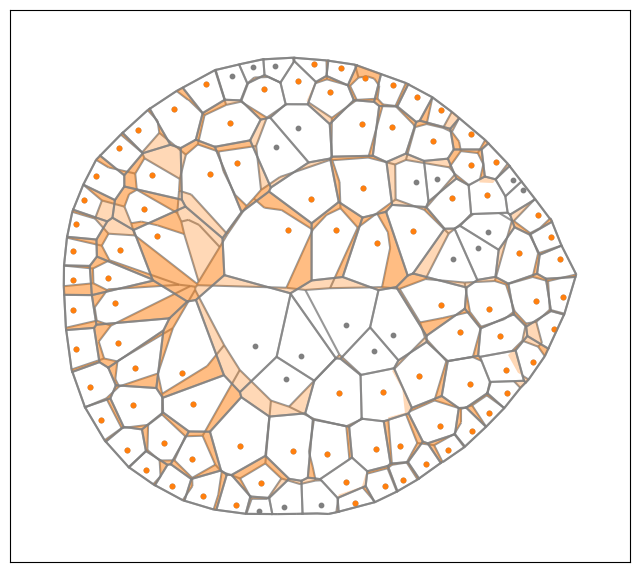

In [24]:
# hydathodes:
figure_plot.plot_overlap_diff(G, bounded_regions, seeds, single_dot, type = 'dot')

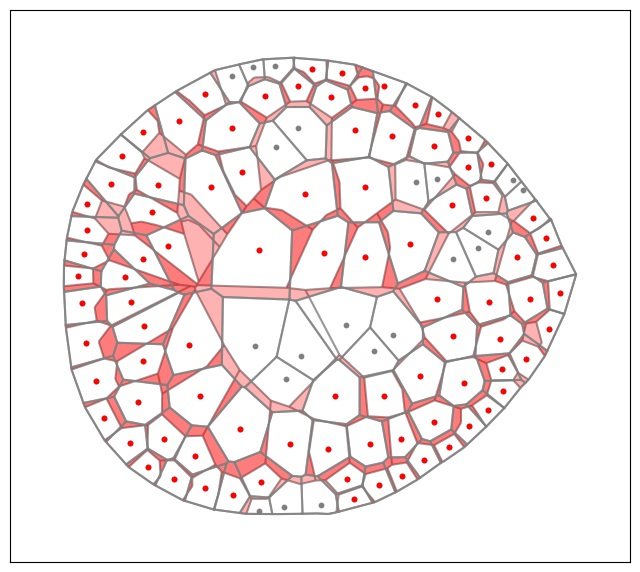

In [25]:
# centroid:
figure_plot.plot_overlap_diff(G, bounded_regions= centroid_bounded_regions, seeds = centroid_seeds, single_dot =  single_dot, type = 'centroid')

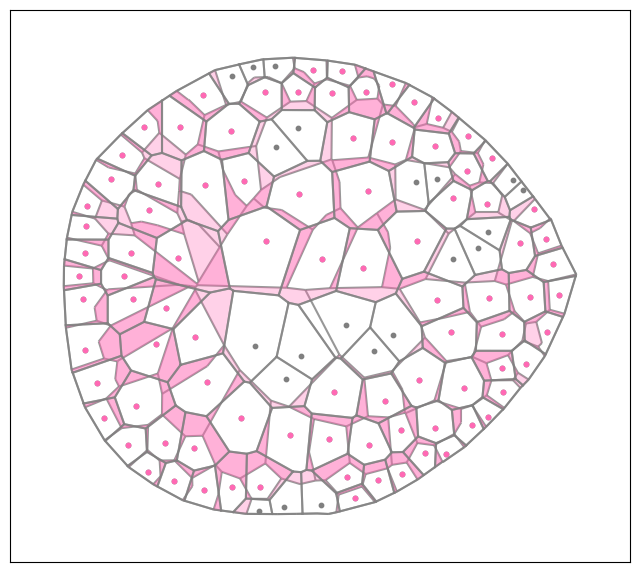

In [26]:
# midpoint:
figure_plot.plot_overlap_diff(G, bounded_regions= midpoint_bounded_regions, seeds = midpoint_seeds, single_dot =  single_dot, type = 'midpoint')

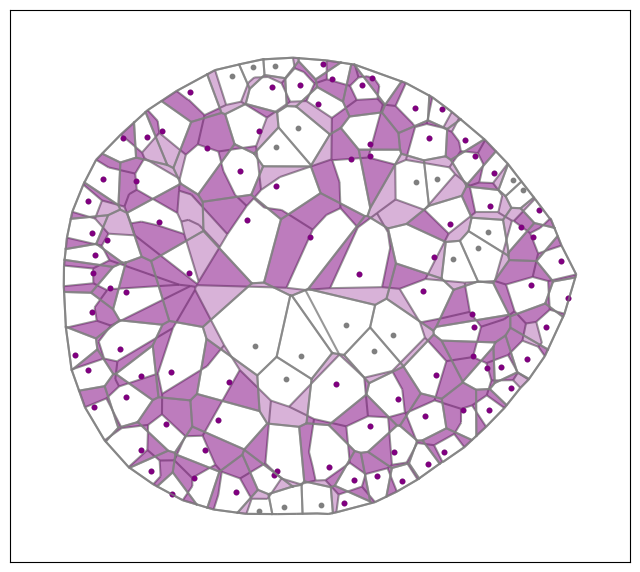

In [27]:
# random:
figure_plot.plot_overlap_diff(G, bounded_regions = random_bounded_regions, seeds = random_seeds, single_dot =  single_dot, type = 'random')

-----

## Perform Voronoi III test

By using the shared edges of adjacent polygons, we construct a linear system to predict the best center locations give the Voronoi geometry.

In [28]:
s_list, b_list = center_predict.slope_intercept(shared_edges_mat, adj_faces_mat)

num_dot = len(G.graph['dots_passed'])

predicted_centers = center_predict.solve_lin_system(s_list, b_list, num_dot)

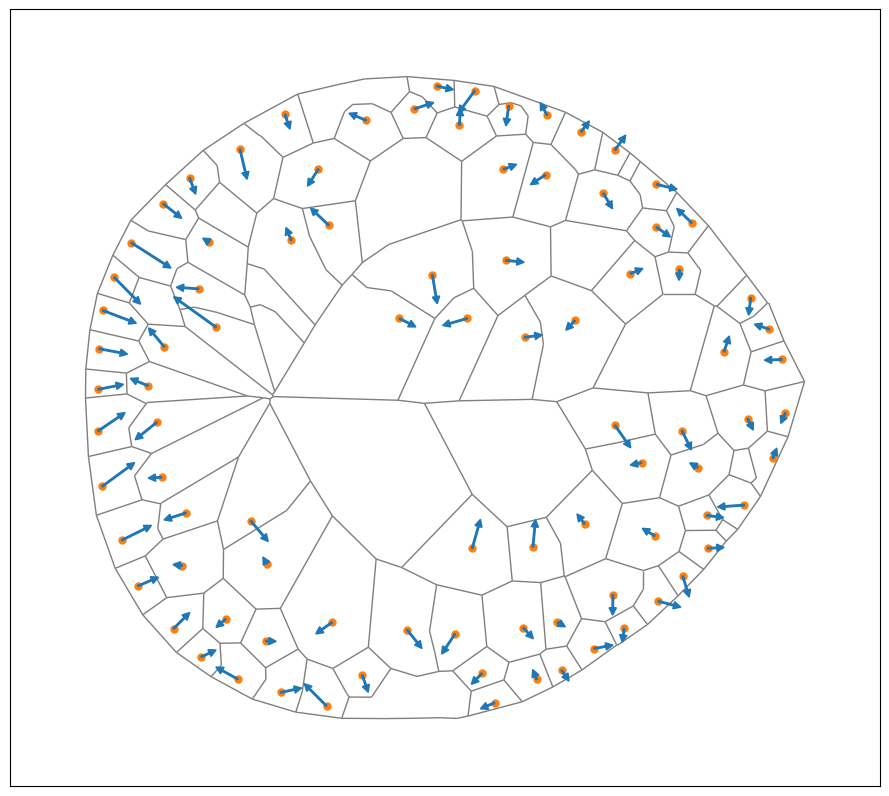

In [29]:
# the arrow is pointing from the hydathodes to predicted centers
figure_plot.plot_mismatch_vec(G, predicted_centers)

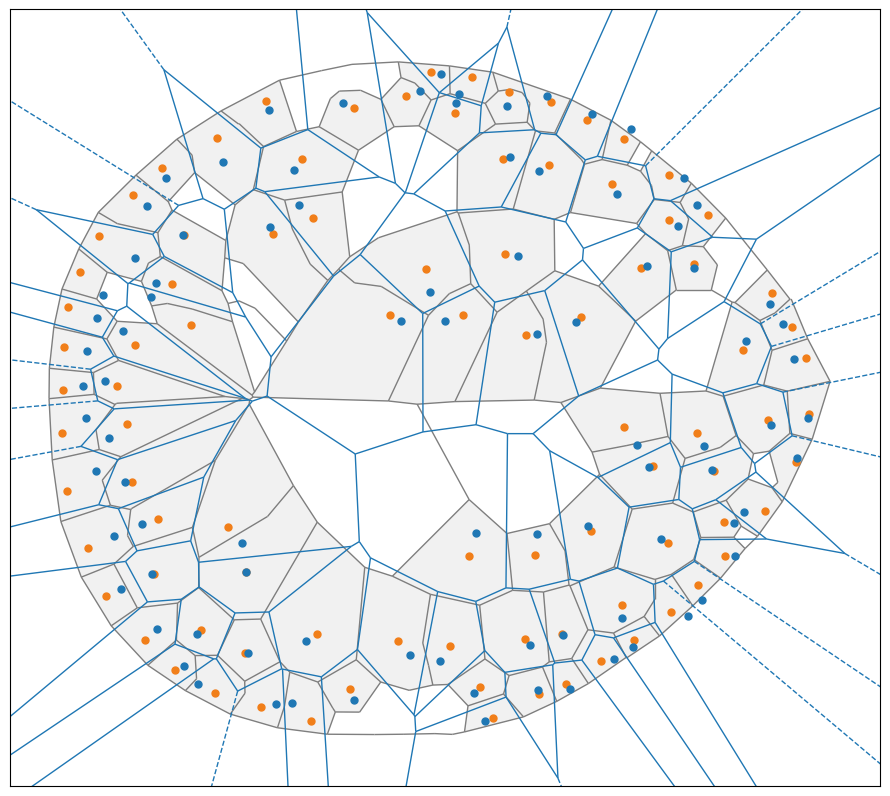

In [30]:
# overlap between the true Voronoi given the predicted centers, and the vein graph; 
# can see the edges agrees very well for the two graphs.
figure_plot.plot_predicted_voronoi(G, predicted_centers)
